In [1]:
import numpy as np, matplotlib.pyplot as plt
from qiskit import *
from qiskit.tools.visualization import plot_histogram, plot_distribution
from qiskit.tools.monitor import job_monitor

plt.style.use(['science', 'notebook', 'grid', 'dark_background'])

The *Deutch-Jorza Algorithm* is simply a quantum algorithm employed to solve the *Deutch-Jorza Problem,* which involves determining whether a given binary function is constant or balanced. This algorithm does this with just **one query** to the function, impossible to achieve classically.

Given a function with $n$-bit strings as input and one bit as output:$$f: \{0,1\}^n \rightarrow \{0,1\}$$ as a nonreversible function.

$f$ is either constant or balanced:$$\begin{gather*}\mathrm{constant\,function:}&\forall\,x\in\{0,1\}^n,\,f(x)=b\\\mathrm{balanced\,function:}&\forall\,x\in\mathscr{H},\,f(x)=0,\;\forall\,x\notin\mathscr{H},\,f(x)=1\end{gather*}$$ where $\mathscr{H}\subset\{0,1\}^n$ is the set of all $n$-bit strings with an even number of 1s, and $\|\mathscr{H}\|=2^{n-1}$ is its cardinality.

We have to
1. Initialize two quantum registers, one containing n input bits and one containing a single output bit; both set to 0,
2. Apply a Hadamard Gate to each input bit to create a superposition of all possible input states,
3. Apply a quantum oracle to the registers, which performs the function evaluation on the input bits and stores the result in the output bit,
4. Apply another Hadamard Gate to each input bit to return them to their original basis states, and
5. Measure the input bits and use their values to determine whether the function is balanced or constant.

In [2]:
n = 5

balanced_oracle = QuantumCircuit(n + 1)
b_str = '10010'

for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

balanced_oracle.barrier()

for qubit in range(n):
    balanced_oracle.cx(qubit, n)
balanced_oracle.barrier()

for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)
dj_circuit = QuantumCircuit(n+1, n)

for qubit in range(n):
    dj_circuit.h(qubit)

In [3]:
dj_circuit.x(n)
dj_circuit.h(n)

dj_circuit = dj_circuit & balanced_oracle

for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

Measuring:

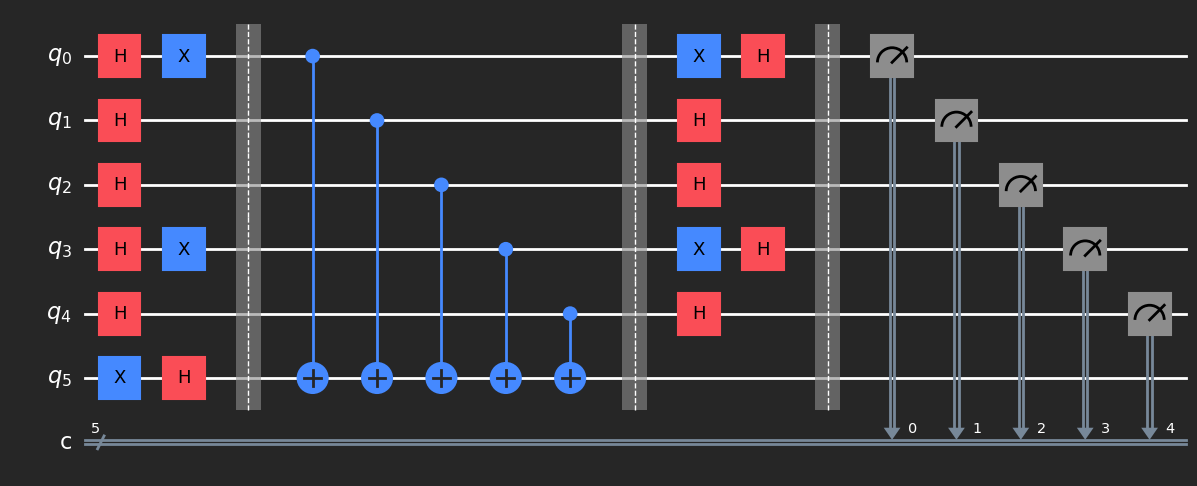

In [4]:
for i in range(n):
    dj_circuit.measure(i, i)

dj_circuit.draw('mpl', style = 'iqx-dark')

Now we can make a blackbox function called the *Oracle* that maps the input qubits to the output qubit, and it performs the operation $$\begin{align*}U_f\left|x\right\rangle\left|y\right\rangle&=\left|x\right\rangle\left|y\oplus f(x)\right\rangle\\U_f\left|x\right\rangle\left|y\right\rangle&=\left|x\right\rangle\left|y\oplus f(x)\right\rangle\end{align*}$$ 

In [5]:
def dj_oracle(case, n):
    oracle_qc = QuantumCircuit(n + 1)
    
    if case == 'balanced':
        b = np.random.randint(1, 2 ** n)
        b_str = format(b, '0' + str(n) + 'b')

        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
    
    if case == 'constant':
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)

    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = 'Oracle'

    return oracle_gate

In [6]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n + 1, n)

    dj_circuit.x(n)
    dj_circuit.h(n)

    for qubit in range(n):
        dj_circuit.h(qubit)

    dj_circuit.append(oracle, range(n + 1))

    for qubit in range(n):
        dj_circuit.h(qubit)

    for i in range(n):
        dj_circuit.measure(i, i)

    return dj_circuit

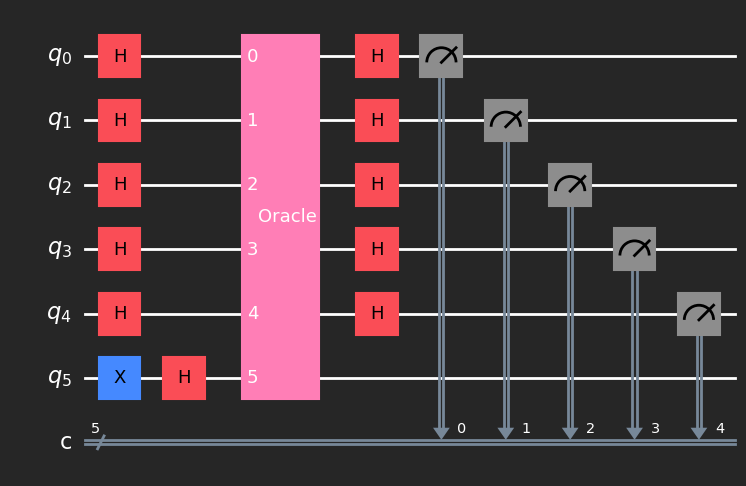

In [7]:
n = 5
case = 'constant' # CHANGE THIS AS YOU PLEASE {balanced, constant}

oracle_gate = dj_oracle(case, n) 
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw('mpl', style = 'iqx-dark')

Testing on an IBMQ Quantum Computer:

C:\Users\DELL\AppData\Local\Temp\ipykernel_12656\1273227115.py:1: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  provider = IBMQ.load_account()
C:\Users\DELL\AppData\Local\Temp\ipykernel_12656\1273227115.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


Job Status: job has successfully run


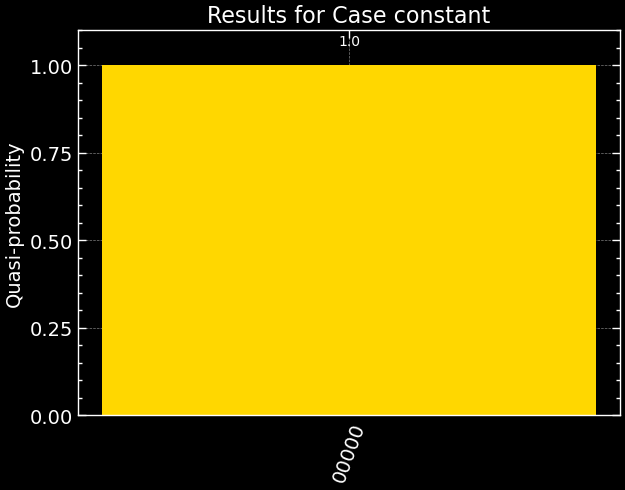

In [8]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')

transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level = 3)
job = backend.run(transpiled_dj_circuit)
job_monitor(job, interval = 2)

results = job.result()
answer = results.get_counts()
plot_distribution(answer, title = f'Results for Case {case}', color = 'gold')

While the 'balanced' case **always** returns a state $\ket{11111}$, while for constant functions it's always a **fixed** state, or $\ket{00000}$.